# When to learn? 

Keeping track of environmental modifications is an important asset to survive and to properly perform spatial navigation for both animals and robots. Despite the extensive research on the role of the mammalian hippocampus in encoding and represent the animals spatial location, how the hippocampus detects novelty is still unclear. Hippocampal models for spatial encoding are often trained and tested within static environments, whereas in the real world the explored environments are in constant modifications. Here, we present a simple, yet generalizable model of novelty detection encapsulated within hippocampal populations of entorhinal (EC) grid- and sensory-cells. The model relies on a sequential autoencoder architecture and learns to reproduce population vector activity from lateral and medial EC cells. Further, we discuss possible scenarios where this model could be used for novelty detection and trigger learning, and suggest a possible hippocampal circuitry capable of novelty detection.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import stats

import tensorflow as tf
from tensorflow import keras    
from keras.models import Model
from keras import backend as K

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def G_rate_map(arena_size=[100,100], theta=0., phase=[50,50], lamb=500):
    '''
    Grid cells activity maps as presented in:
    - Blair et al. (2007), equation (1)
    - Almeida et al. (2009), equation (1)
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        theta (float)             : Grid rotation (assume to be either 0°, 20°, or 40°, in degrees)
        Phase (tuple of int)      : Spatial phase of the grid     
        lamb (int)                : Distance between firing fields
    '''

    G = np.zeros(arena_size)
    a = 0.3
    b = -3./2.        
    lambV = (4*np.pi)/(np.sqrt(3*lamb))
    theta = np.radians(theta)

    for ind, val in np.ndenumerate(G):

        tmp_g = 0
        for i in np.deg2rad(np.linspace(-30,90,3)):
            u_f = (np.cos(i+theta),np.sin(i+theta))
            dist = (ind[0]-phase[0],ind[1]-phase[1])
            tmp_g += np.cos( lambV * np.dot(u_f,dist) )
            
        tmp_g = np.exp(np.dot(a,(tmp_g)+b))-1
        G[ind] = tmp_g
        
    
    ## Normalize if for learning and LEC integration effiency 
    if G.min()<0: G += abs(G.min())
    G = (G - G.min())/(G.max()-G.min())
        
    return G

In [35]:
def LEC_rate_map(arena_size=[100,100], filled_perc=0.3):
    
    '''
    Build 'sort of' LEC cells. See Renno-Costa et al. 2010
    These cells have X (filled_perc) number of firing fields randomly spread over the arena
    Params:
        arena_size (tuple of int) : define rate_map dimensions
        filled_perc (float)       : define how much area this cell is receptive to (value from 0 to 1).
    '''
    
    a = np.zeros(36)
    a[: int(filled_perc*25) ] = 1
    np.random.shuffle(a)
    a = a.reshape(6,6)
    
    b = np.zeros((arena_size[0], arena_size[1]))
    
    for i in range(arena_size[0]):
        for j in range(arena_size[1]):
            idx1 = i * len(a) / arena_size[0]
            idx2 = j * len(a) / arena_size[1]
            b[i][j] = a[idx1][idx2]

    arena = scipy.ndimage.filters.gaussian_filter(b, 4)
    arena *= 0.6
    
    return arena

# Build training data structure

<li> Each input vector represents the population vector activity of MEC and LEC cells at a given location.
<li> Half the vector contains MEC cells, the other half LEC cells.
<li> For the data-structure we will set a population of MEC cells and 2 populations of LEC cells (LEC_1 and LEC_2)
<li> We will train an autoencoder to classify the input vector (MEC + LEC_1).
<li> After training, we will test the accuracy error by progressively changing from LEC_1 context to LEC_2 context. (a la rate-remapping morphing Leutgeb)

In [36]:
n_grid = 200
n_lec = 200

arena_size = [50,50]

grid_data = []
for ii in range(n_grid):
    lamb  = np.random.randint(500,2000)
    phase = np.random.randint(0,arena_size[0],2)  ## This is assuming arena is a square
    g = G_rate_map(arena_size=arena_size, phase=phase, lamb=lamb)
    grid_data.append( g.flatten()  )
grid_data = np.array(grid_data)


lec_1_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_1_data.append( l.flatten()  )
lec_1_data = np.array(lec_1_data)

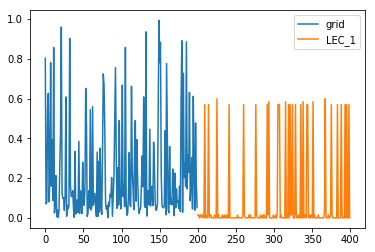

In [37]:
total_positions = arena_size[0] * arena_size[1]
pos = 0  ## position index

## The input vector containing grid and LEC_1 cells at a given position
input_v = np.hstack((grid_data[:,pos] , lec_1_data[:,pos]))  

plt.plot( np.arange(0,input_v.size/2), input_v[:input_v.size/2], label='grid')
plt.plot( np.arange(input_v.size/2,input_v.size), input_v[input_v.size/2:], label='LEC_1')
plt.legend()

In [38]:
# Make data structure combining both MEC and LEC_1
data = np.vstack((grid_data , lec_1_data))
data = data.T

# Illustrations

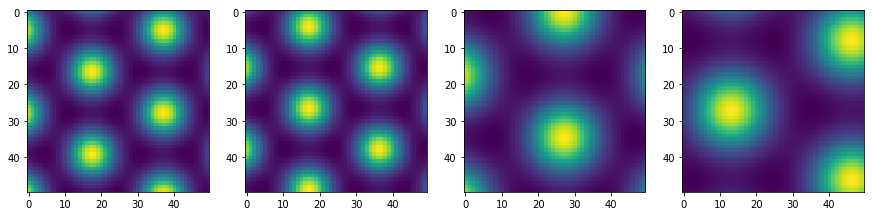

In [52]:
plt.figure(figsize=(15,4))
count = 1
for cell_n in [26, 10, 16, 27]:
    plt.subplot(1,4,count)
    plt.imshow(grid_data[cell_n].reshape(50,50))
    count+=1
    
plt.savefig('../figures/grid_cells_examples.pdf')    

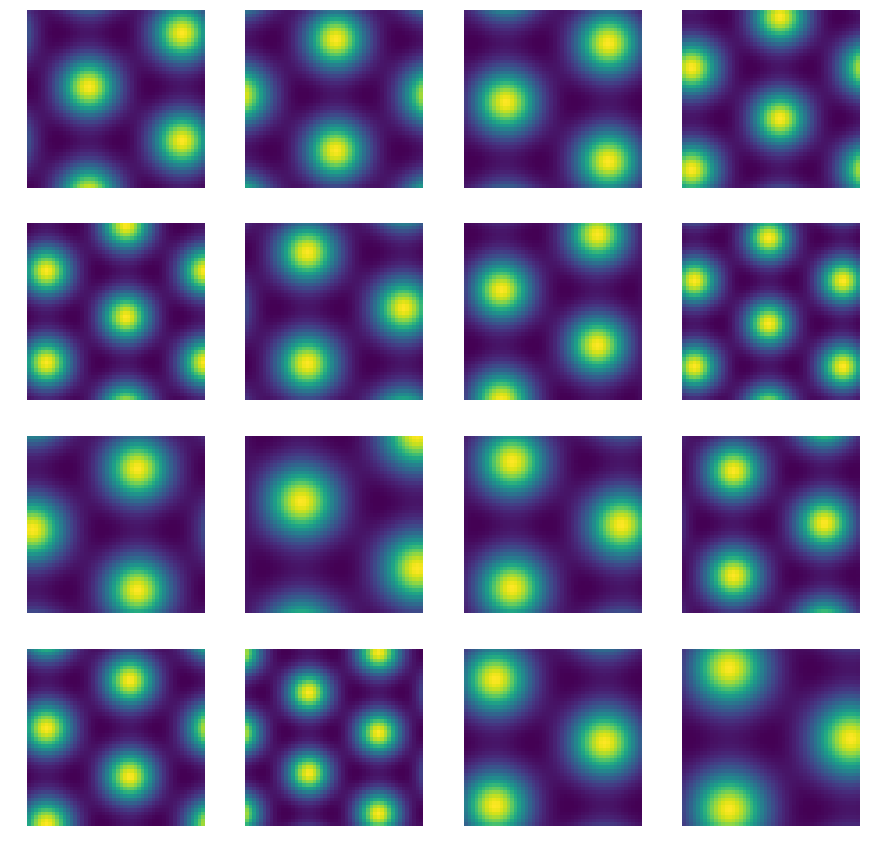

In [55]:
plt.figure(figsize=(15,15))
count = 1
for cell_n in np.random.randint(0,200,4*4):
    plt.subplot(4,4,count)
    plt.imshow(grid_data[cell_n].reshape(50,50))
    plt.axis('off')
    count+=1
    
plt.savefig('../figures/grid_cells_stack.pdf')

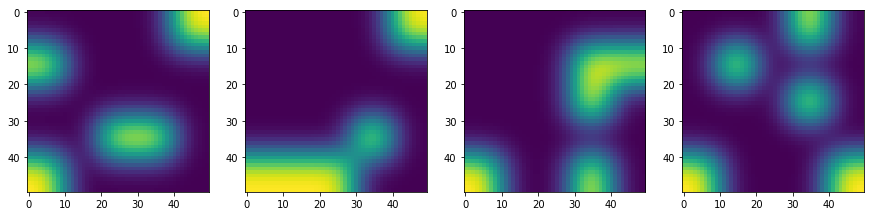

In [56]:
plt.figure(figsize=(15,4))
count = 1
for cell_n in [26, 10, 16, 27]:
    plt.subplot(1,4,count)
    plt.imshow(lec_1_data[cell_n].reshape(50,50))
    count+=1
    
plt.savefig('../figures/lec_cells_examples.pdf')    

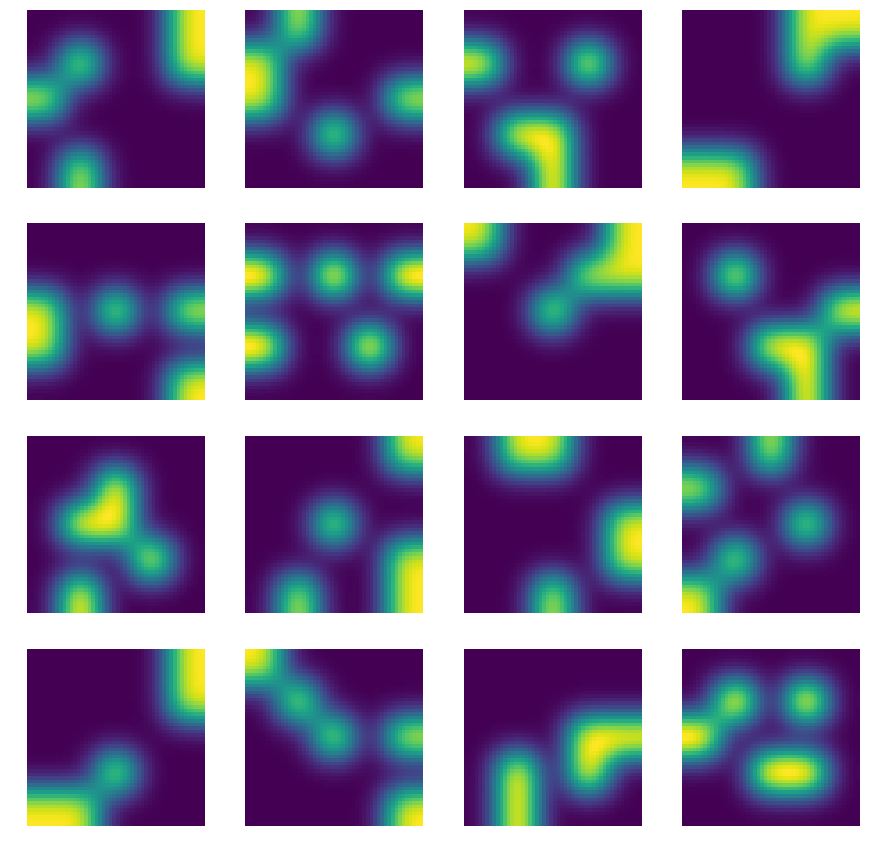

In [57]:
plt.figure(figsize=(15,15))
count = 1
for cell_n in np.random.randint(0,200,4*4):
    plt.subplot(4,4,count)
    plt.imshow(lec_1_data[cell_n].reshape(50,50))
    plt.axis('off')
    count+=1
    
plt.savefig('../figures/lec_cells_stack.pdf')

# TensorFlow model

In [39]:
model = keras.Sequential([
keras.layers.Dense(200, activation=tf.nn.relu, input_shape=(data.shape[1],)),
keras.layers.Dense(50, activation=tf.nn.sigmoid),
keras.layers.Softmax(),
keras.layers.Dense(200, activation=tf.nn.tanh),
keras.layers.Dense(data.shape[1])
])

optimizer = tf.train.RMSPropOptimizer(0.001)

model.compile(loss='mse',
            optimizer=optimizer,
            metrics=['mae'])

In [40]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                10050     
_________________________________________________________________
softmax_1 (Softmax)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_7 (Dense)              (None, 400)               80400     
Total params: 180,850
Trainable params: 180,850
Non-trainable params: 0
_________________________________________________________________


In [41]:
idx = np.arange(data.shape[0])
np.random.shuffle(idx)

In [42]:
EPOCHS = 1000
history = model.fit(data[idx], data[idx], epochs=EPOCHS, validation_split=0.2, verbose=0)

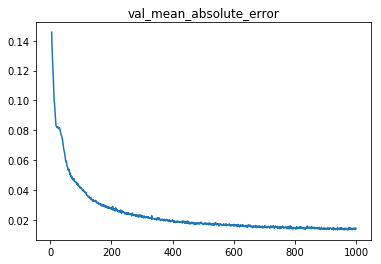

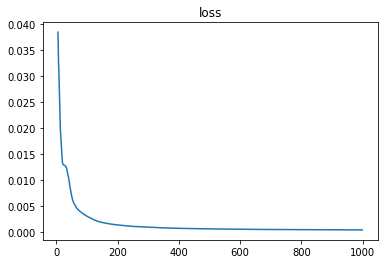

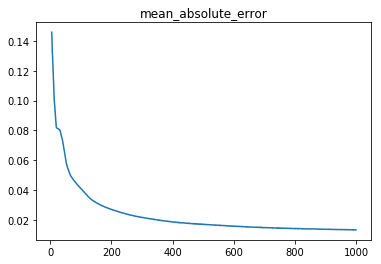

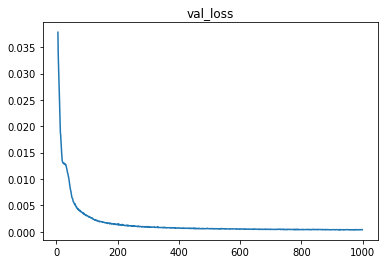

In [43]:
for kk in history.history.keys():
    plt.plot(  history.epoch[5:], history.history[kk][5:] )
    plt.title(kk)
    plt.show()

distance:  0.44829233369773747


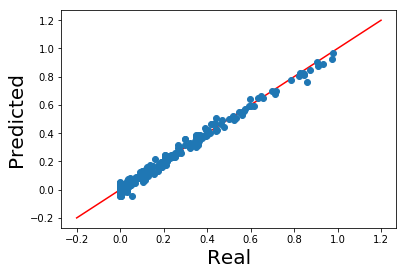

In [44]:
pos_n = 10

pred = model.predict(  np.array([data[pos_n]])  ).T


plt.plot( [-.2,1.2],[-.2,1.2],'r'  )
plt.plot( data[pos_n], pred , 'o')

plt.xlabel('Real', fontsize=20)
plt.ylabel('Predicted', fontsize=20)


print 'distance: ' , np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) ))

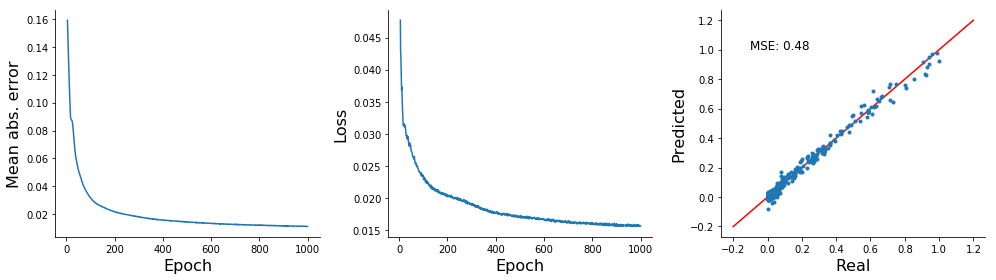

In [80]:
fig , ax = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(14)
fig.set_facecolor('white')



ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[0])
    
plt.plot(  history.epoch[5:], history.history['mean_absolute_error'][5:] )
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Mean abs. error', fontsize=16)



ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.sca(ax[1])

plt.plot(  history.epoch[5:], history.history['val_loss'][5:] )
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)



ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)
plt.sca(ax[2])

pos_n = 10
pred = model.predict(  np.array([data[pos_n]])  ).T
tt = 'MSE: ' + str( np.round(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )),2) )

plt.plot( [-.2,1.2],[-.2,1.2],'r'  )
plt.plot( data[pos_n], pred , 'o', markersize=3)
plt.text(-.1,1,tt, fontsize=12)
plt.xlabel('Real', fontsize=16)
plt.ylabel('Predicted', fontsize=16)


plt.tight_layout()


# plt.savefig('../figures/model_learning.pdf')

In [45]:
error_log = []
for pos_n in range(data.shape[0]):

    pred = model.predict(  np.array([data[pos_n]])  ).T

    error_log.append(np.sqrt(np.sum(np.power(data[pos_n] - pred[:,0], 2) )))

# Test Error by including LEC_2 cells

In [21]:
## Build a new LEC context (LEC_2)
lec_2_data = []
for ii in range(n_lec):
    l = LEC_rate_map(arena_size=arena_size, filled_perc=0.2)
    lec_2_data.append( l.flatten()  )
lec_2_data = np.array(lec_2_data)

In [22]:
# Make a new data structure combining both MEC and LEC_2
data2 = np.vstack((grid_data , lec_2_data))
data2 = data2.T

In [23]:
error_log_total_mean = []
error_log_total_std = []
error_log_total_sem = []

for dd in np.linspace(0,1,11):

    new_data = np.zeros_like(data)

    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)
    
    new_data[ idx[ int(idx.size*dd) : ]  ] = data[ idx[ int(idx.size*dd) :] ]
    new_data[ idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]


    error_log = []
    for pos_n in range(1900):

        pred = model.predict(  np.array([new_data[pos_n]])  ).T
        error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))
#     error_log.append( np.sum(np.power(new_data[pos_n] - pred[:,0], 2) ))

    error_log_total_mean.append(  np.mean(error_log) )
    error_log_total_std.append(  np.std(error_log) )
    error_log_total_sem.append(  stats.sem(error_log) )


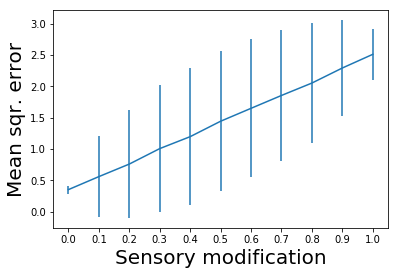

In [24]:
plt.errorbar(  range(len(error_log_total_mean)), error_log_total_mean, yerr=error_log_total_std)

plt.xticks(range(11), np.round(np.linspace(0,1,11),2) )

plt.ylabel("Mean sqr. error", fontsize=20)
plt.xlabel("Sensory modification", fontsize=20)

In [18]:
## Mean sqr. error of input and prediction of maximal distance would be:
np.sqrt(np.sum(np.power(np.ones(200)-np.zeros(200), 2) ))

14.142135623730951

# As if it was during navigation

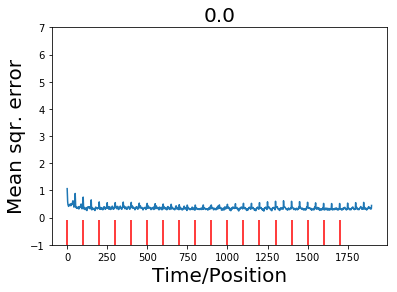

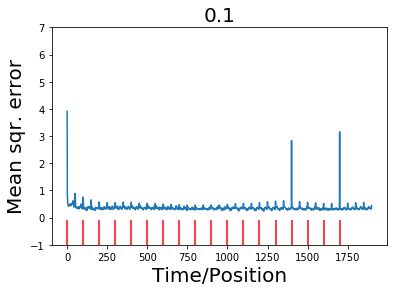

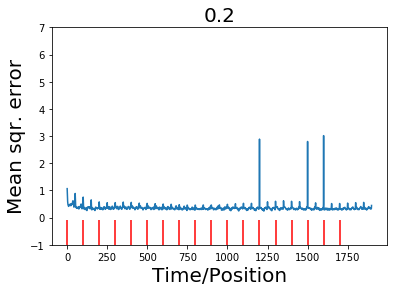

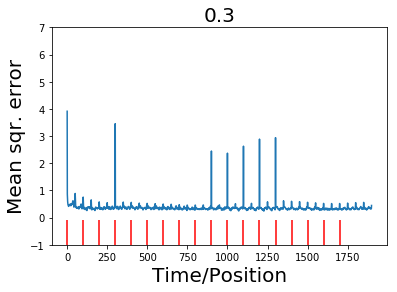

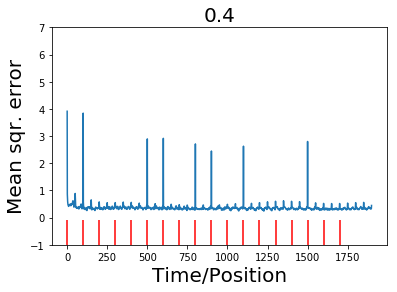

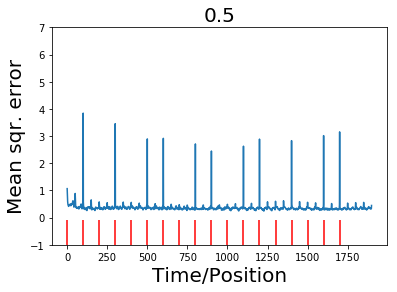

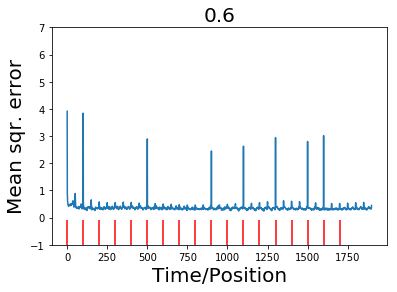

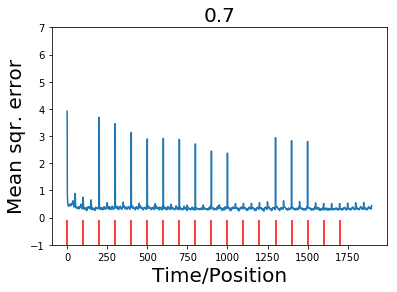

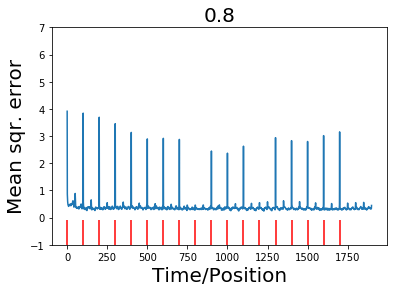

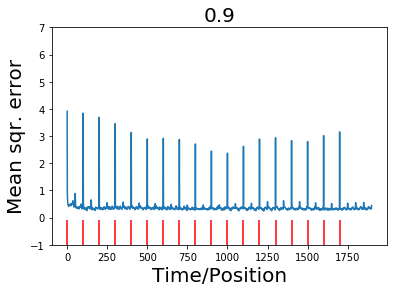

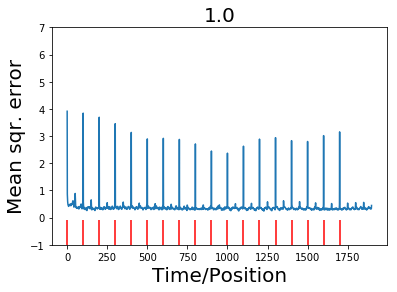

In [25]:
modification_times = np.linspace(0,1700,18)


detected_modification = []
for dd in np.linspace(0,1,11):


    new_data = np.zeros_like(data)

    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)

    new_data[ idx[ int(idx.size*0) : ]  ] = data[ idx[ int(idx.size*0) :] ]
    new_data[ idx[ : int(idx.size*0) ]  ] = data2[ idx[ : int(idx.size*0)  ] ]


    error_log = []
    for pos_n in range(1900):

        if pos_n in modification_times:


            new_data_2 = np.zeros_like(data)

            idx = np.arange(data.shape[0])
            np.random.shuffle(idx)

            new_data_2[ idx[ int(idx.size*dd) : ]  ] = data[ idx[ int(idx.size*dd) :] ]
            new_data_2[ idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]

            pred = model.predict(  np.array([new_data_2[pos_n]])  ).T

            error_log.append(np.sqrt(np.sum(np.power(new_data_2[pos_n] - pred[:,0], 2) )))


        else:
            pred = model.predict(  np.array([new_data[pos_n]])  ).T

            error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))


    error_log = np.array(error_log)    

    detected_modification.append( np.where(error_log>2)[0].size / float(modification_times.size) )


    plt.plot(error_log)
    plt.vlines(modification_times, -1,-.1,'r')
    plt.title(np.round(dd,2), fontsize=20)
    plt.ylabel("Mean sqr. error", fontsize=20)
    plt.xlabel("Time/Position", fontsize=20)
    plt.ylim(-1,7)    
    plt.show()

In [20]:
modification_times = np.linspace(0,1700,18)

detected_modification_mean = []
detected_modification_std = []
detected_modification_sem = []

for dd in np.linspace(0,1,11):

    tmp_detected_modification = []
    
    for ii in range(20):

        new_data = np.zeros_like(data)

        idx = np.arange(data.shape[0])
        np.random.shuffle(idx)

        new_data[ idx[ int(idx.size*0) : ]  ] = data[ idx[ int(idx.size*0) :] ]
        new_data[ idx[ : int(idx.size*0) ]  ] = data2[ idx[ : int(idx.size*0)  ] ]


        error_log = []
        for pos_n in range(1900):

            if pos_n in modification_times:


                new_data_2 = np.zeros_like(data)

                idx = np.arange(data.shape[0])
                np.random.shuffle(idx)

                new_data_2[ idx[ int(idx.size*dd) : ]  ] = data[ idx[ int(idx.size*dd) :] ]
                new_data_2[ idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]

                pred = model.predict(  np.array([new_data_2[pos_n]])  ).T
                
                error_log.append(np.sqrt(np.sum(np.power(new_data_2[pos_n] - pred[:,0], 2) )))



            else:
                pred = model.predict(  np.array([new_data[pos_n]])  ).T

                error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))


        error_log = np.array(error_log)    

        tmp_detected_modification.append( np.where(error_log>2)[0].size / float(modification_times.size) )
        
    detected_modification_mean.append(  np.mean(np.array(tmp_detected_modification)) )
    detected_modification_std.append(  np.mean(np.array(tmp_detected_modification)) )
    detected_modification_sem.append(  stats.sem(np.array(tmp_detected_modification)) )

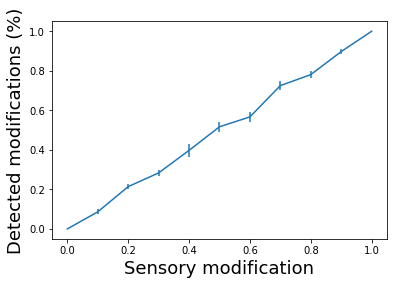

In [21]:
plt.errorbar(  np.linspace(0,1,11), np.array(detected_modification_mean), yerr=detected_modification_sem)

# plt.xticks(range(11), np.round(np.linspace(0,1,11),2) )

plt.ylabel("Detected modifications (%)", fontsize=18)
plt.xlabel("Sensory modification", fontsize=18)

# plt.plot([0,1],[0,1])

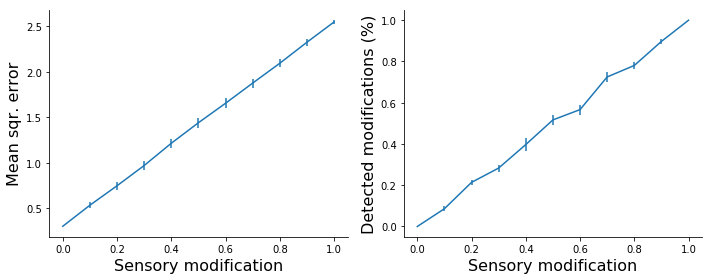

In [91]:
fig , ax = plt.subplots(1,2)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.set_facecolor('white')



ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
plt.sca(ax[0])
plt.errorbar(  range(len(error_log_total_mean)), error_log_total_mean, yerr=np.array(error_log_total_sem)*2)
plt.xticks(np.linspace(0,10,6), np.round(np.linspace(0,1,6),2) )
plt.ylabel("Mean sqr. error", fontsize=16)
plt.xlabel("Sensory modification", fontsize=16)




ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
plt.sca(ax[1])
plt.errorbar(  np.linspace(0,1,11), np.array(detected_modification_mean), yerr=detected_modification_sem)
plt.ylabel("Detected modifications (%)", fontsize=16)
plt.xlabel("Sensory modification", fontsize=16)



plt.tight_layout()


plt.savefig('../figures/model_error_and_detection.pdf')

In [96]:
modification_times = np.linspace(0,1700,18)
error_log_all_for_plot = []

for dd in np.linspace(0,1,6):


    new_data = np.zeros_like(data)

    idx = np.arange(data.shape[0])
    np.random.shuffle(idx)

    new_data[ idx[ int(idx.size*0) : ]  ] = data[ idx[ int(idx.size*0) :] ]
    new_data[ idx[ : int(idx.size*0) ]  ] = data2[ idx[ : int(idx.size*0)  ] ]


    error_log = []
    for pos_n in range(1900):

        if pos_n in modification_times:


            new_data_2 = np.zeros_like(data)

            idx = np.arange(data.shape[0])
            np.random.shuffle(idx)

            new_data_2[ idx[ int(idx.size*dd) : ]  ] = data[ idx[ int(idx.size*dd) :] ]
            new_data_2[ idx[ : int(idx.size*dd) ]  ] = data2[ idx[ : int(idx.size*dd)  ] ]

            pred = model.predict(  np.array([new_data_2[pos_n]])  ).T

            error_log.append(np.sqrt(np.sum(np.power(new_data_2[pos_n] - pred[:,0], 2) )))


        else:
            pred = model.predict(  np.array([new_data[pos_n]])  ).T

            error_log.append(np.sqrt(np.sum(np.power(new_data[pos_n] - pred[:,0], 2) )))


    error_log = np.array(error_log)

    error_log_all_for_plot.append(error_log)
    

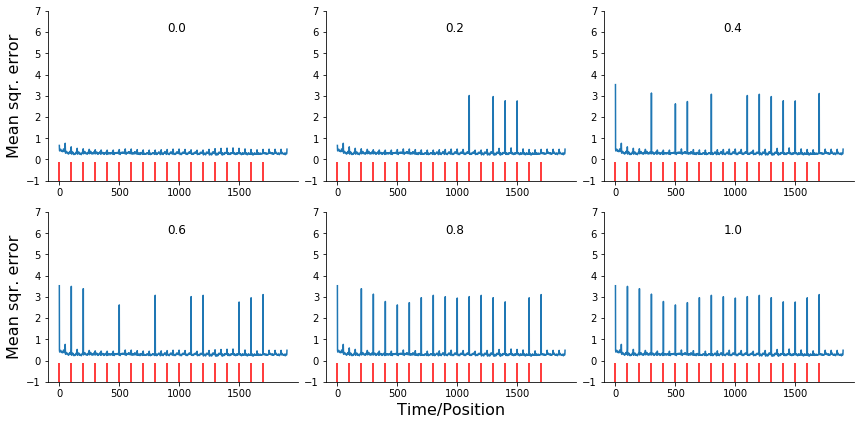

In [132]:
fig , ax = plt.subplots(2,3)
fig.set_figheight(6)
fig.set_figwidth(12)
fig.set_facecolor('white')


for ii in range(len(error_log_all_for_plot)):
    
    ax[ii/3, ii%3].spines['right'].set_visible(False)
    ax[ii/3, ii%3].spines['top'].set_visible(False)
    plt.sca(ax[ii/3, ii%3])

    plt.plot(error_log_all_for_plot[ii])
    plt.vlines(modification_times, -1,-.1,'r')
    
    tt = str(np.round(np.linspace(0,1,6)[ii],2))
    plt.text(900,6,tt, fontsize=12)
    
    if ii%3 == 0: plt.ylabel("Mean sqr. error", fontsize=16)
    if ii/3 == 1 and ii%3 == 1: plt.xlabel("Time/Position", fontsize=16)
    plt.ylim(-1,7)
    
    
plt.tight_layout()    
plt.savefig('../figures/detections.pdf')